In [3]:
import torch 
from torch import nn 
from torch.utils.data import DataLoader 
from torchvision import datasets 
from torchvision.transforms import ToTensor, Lambda 
import matplotlib.pyplot as plt 


device = 'cuda'

train_dataset = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor())

test_dataset = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

train_dataloader = DataLoader(train_dataset, batch_size = 64)
test_dataloader = DataLoader(test_dataset, batch_size = 64)

100%|██████████| 26421880/26421880 [00:07<00:00, 3755252.81it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 104917.50it/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:09<00:00, 487577.05it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [62]:
BATCH_SIZE = 64 
LEARNING_RATE = 2e-4
N_EPOCHS = 10
LEAKY_SLOPE = 0.2
B1_MOMENTUM = 0.5
Z_DIM = 100 
IMAGE_DIM = 28 * 28
HIDDEN_DIM = 128
N_CHANNELS = 1
D_ITER = 5


In [63]:
class Generator(nn.Module):
    def __init__(self, z_dim = Z_DIM, h_dim = HIDDEN_DIM, x_dim = IMAGE_DIM):
        super().__init__()
        self.fc = nn.Linear(z_dim, h_dim * 7 * 7)
        self.gen_stack = nn.Sequential(
            nn.ConvTranspose2d(h_dim, h_dim // 2, kernel_size =4, stride = 2, padding = 1),
            nn.BatchNorm2d(h_dim // 2),
            nn.ReLU(),
            nn.ConvTranspose2d(h_dim // 2, N_CHANNELS, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh()
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), HIDDEN_DIM, 7, 7)
        x = self.gen_stack(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.ConvTranspose2d):
                nn.init.normal_(module.weight, 0., 0.02)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)
            

dummy_input = torch.randn(64, Z_DIM).to(device)
gen = Generator().to(device)
gen_output = gen(dummy_input)
print(gen_output.shape)

torch.Size([64, 1, 28, 28])


In [64]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc_stack = nn.Sequential(
            nn.Conv2d(N_CHANNELS, HIDDEN_DIM // 2, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(LEAKY_SLOPE),
            nn.Conv2d(HIDDEN_DIM // 2, HIDDEN_DIM, kernel_size = 4, stride = 2, padding = 1),
            nn.BatchNorm2d(HIDDEN_DIM),
            nn.LeakyReLU(LEAKY_SLOPE)
        )
        self.fc = nn.Linear(HIDDEN_DIM * 7 * 7, 1)

    def forward(self, x):
        x = self.disc_stack(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, 0., 0.02)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, 0., 0.02)
                nn.init.constant_(module.bias, 0)


In [65]:
import time 

gen_losses = []
disc_losses = []
def train_loop(dataloader, generator, discriminator, g_optimizer, d_optimizer, loss_fn):
    fixed_noise = torch.randn(64, Z_DIM).to(device)
    size = len(dataloader.dataset)

    for batch, (X, _) in enumerate(dataloader):
        for _ in range(D_ITER):
            X = X.to(device)
            batch_size = X.shape[0]

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # train the discriminator 
            d_optimizer.zero_grad()
            real_output = discriminator(X)
            real_loss = loss_fn(real_output, real_labels)

            z = torch.randn(batch_size, Z_DIM).to(device)
            fake_output = generator(z)
            fake_output = fake_output.detach()
            fake_output = discriminator(fake_output)
            fake_loss = loss_fn(fake_output, fake_labels)

            disc_loss = real_loss + fake_loss 
            disc_losses.append(disc_loss.item())
            disc_loss.backward()
            d_optimizer.step()

        # train the generator
        g_optimizer.zero_grad()
        z = torch.randn(batch_size, Z_DIM).to(device)
        fake_output = generator(z)
        fake_output = discriminator(fake_output)
        gen_loss = loss_fn(fake_output, real_labels)
        gen_losses.append(gen_loss.item())
        gen_loss.backward()

        g_optimizer.step()

        if batch % 100 == 0:
            print(f"loss D: {disc_loss.item():.4f}, loss G: {gen_loss.item():.4f}")


def test_loop(dataloader, generator, discriminator, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            batch_size = X.shape[0]
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            real_output = discriminator(X)
            real_loss = loss_fn(real_output, real_labels)

            z = torch.randn(batch_size, Z_DIM).to(device)
            fake_output = generator(z)
            fake_output = discriminator(fake_output)
            fake_loss = loss_fn(fake_output, fake_labels)

            test_loss += real_loss + fake_loss

    test_loss /= num_batches
    print(f"Avg loss: {test_loss.item():.4f}")



In [66]:
def plot_images(generator, epoch, fixed_noise):
    generator.eval()
    fake_images = generator(fixed_noise).detach().cpu()
    fig = plt.figure(figsize = (8, 8))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(fake_images[i][0], cmap = 'gray')
        plt.axis('off')
    plt.show()
    generator.train()

In [67]:
def plot_losses(gen_losses, disc_losses):
    plt.plot(gen_losses, label = 'D(G(z)) loss')
    plt.plot(disc_losses, label = 'D(x) loss')
    plt.legend()
    plt.show()

In [68]:
g_optimizer = torch.optim.Adam(gen.parameters(), lr = LEARNING_RATE, betas = (B1_MOMENTUM, 0.999))
d_optimizer = torch.optim.Adam(disc.parameters(), lr = LEARNING_RATE, betas = (B1_MOMENTUM, 0.999))
loss_fn = nn.BCEWithLogitsLoss()
fixed_noise = torch.randn(64, Z_DIM).to(device)



Epoch 1
-------------------------------
loss D: 0.0001, loss G: 16.9603
loss D: 0.0000, loss G: 12.4393
loss D: 0.0000, loss G: 14.7042
loss D: 1.7275, loss G: 24.5159
loss D: 0.0024, loss G: 8.3383
loss D: 0.0030, loss G: 8.4563
loss D: 0.0021, loss G: 7.9300
loss D: 0.0011, loss G: 9.0168
loss D: 0.0069, loss G: 8.0115
loss D: 0.0020, loss G: 8.7538
Avg loss: 0.0043


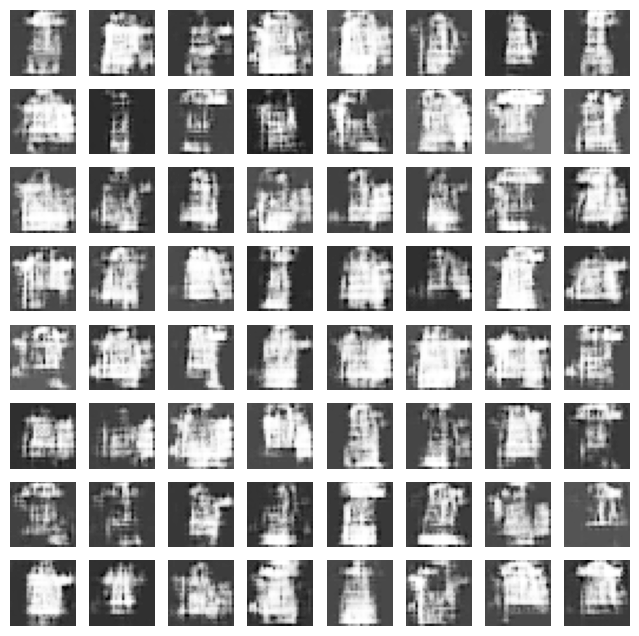

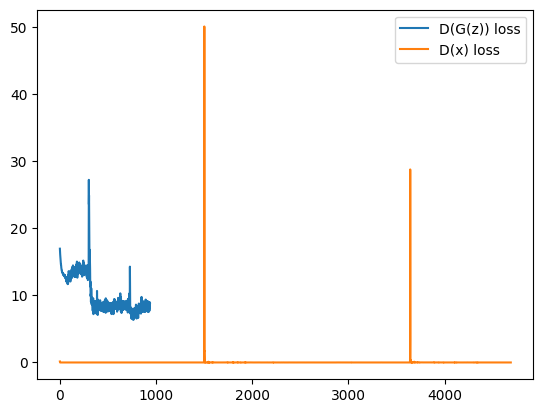

Time taken for epoch 1: 62.625969886779785

Epoch 2
-------------------------------
loss D: 0.0028, loss G: 8.3218
loss D: 0.0015, loss G: 8.3561
loss D: 0.0008, loss G: 8.4054
loss D: 0.0012, loss G: 9.1163
loss D: 0.0003, loss G: 10.3194
loss D: 0.0072, loss G: 8.3847
loss D: 0.0035, loss G: 8.2486
loss D: 0.0021, loss G: 7.9010
loss D: 0.0030, loss G: 7.2318
loss D: 0.0011, loss G: 9.0844
Avg loss: 0.0081


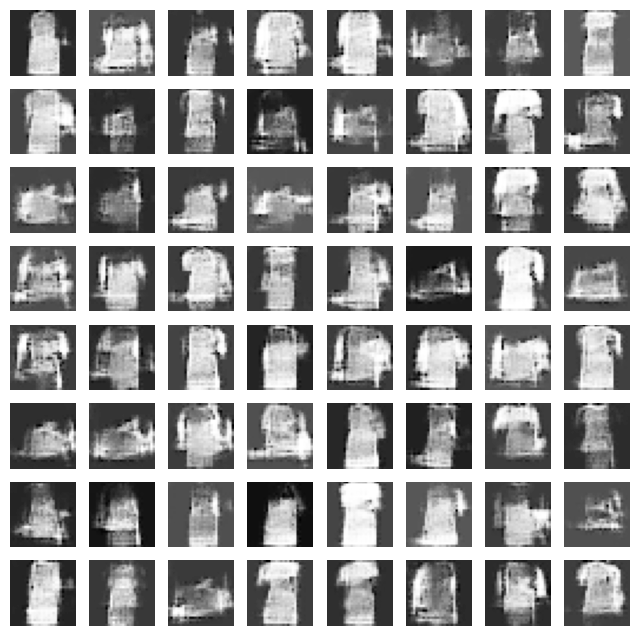

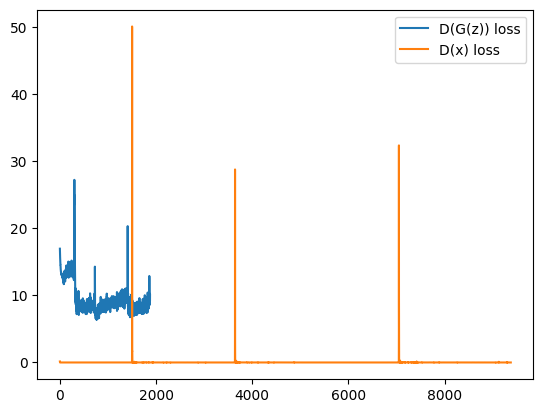

Time taken for epoch 2: 47.50793242454529

Epoch 3
-------------------------------
loss D: 0.0036, loss G: 9.3651
loss D: 0.0048, loss G: 7.9635
loss D: 0.0026, loss G: 7.7809
loss D: 0.0026, loss G: 8.7987
loss D: 0.0014, loss G: 8.6368
loss D: 0.0026, loss G: 8.7877
loss D: 0.0008, loss G: 7.5519
loss D: 0.0075, loss G: 6.5720
loss D: 0.0043, loss G: 7.4269
loss D: 0.0073, loss G: 6.8633
Avg loss: 0.0098


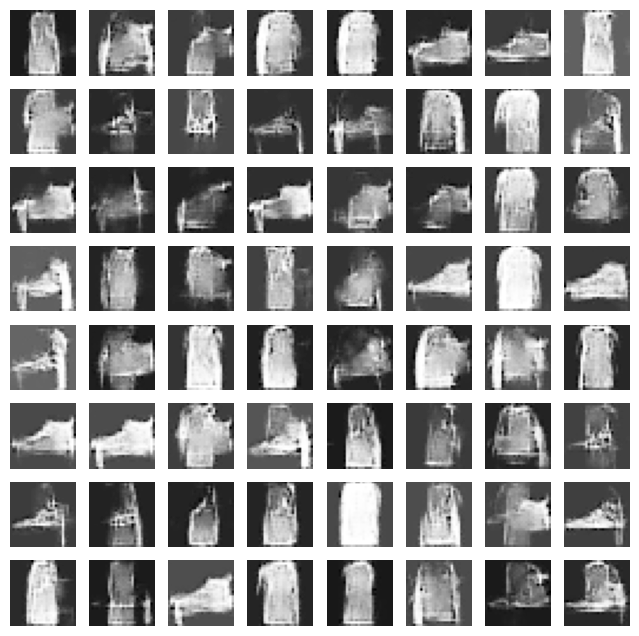

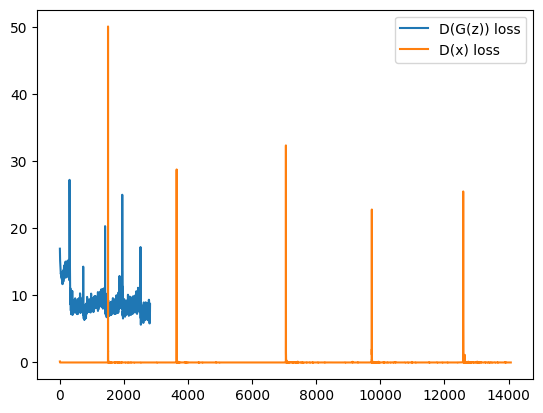

Time taken for epoch 3: 37.96202516555786

Epoch 4
-------------------------------
loss D: 0.0027, loss G: 7.2466
loss D: 0.0086, loss G: 8.4034
loss D: 0.0019, loss G: 8.6984
loss D: 0.0653, loss G: 6.2592
loss D: 0.0060, loss G: 7.5406
loss D: 0.0070, loss G: 6.5094
loss D: 0.0070, loss G: 7.1650
loss D: 0.0036, loss G: 7.1553
loss D: 0.0164, loss G: 5.4380
loss D: 0.0075, loss G: 6.0002
Avg loss: 0.0309


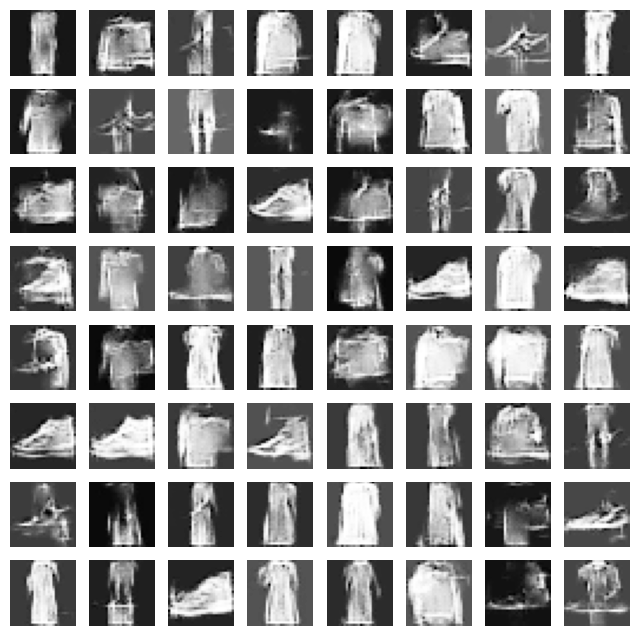

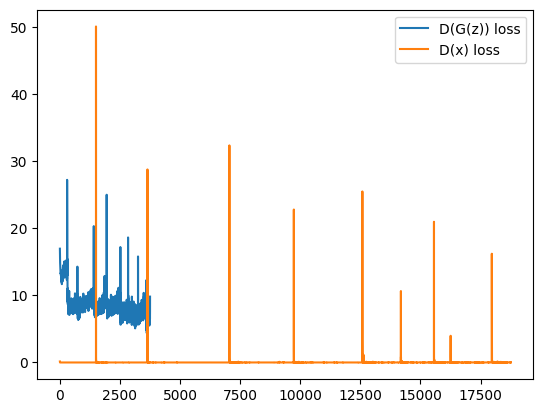

Time taken for epoch 4: 34.58767342567444

Epoch 5
-------------------------------
loss D: 0.0092, loss G: 6.7920
loss D: 0.0058, loss G: 6.9368
loss D: 0.0039, loss G: 7.9457
loss D: 0.0117, loss G: 5.9865
loss D: 0.0066, loss G: 8.0942
loss D: 0.0044, loss G: 7.8537
loss D: 0.0108, loss G: 5.6490
loss D: 0.0075, loss G: 5.8733
loss D: 0.0051, loss G: 6.3591
loss D: 0.0166, loss G: 5.6713
Avg loss: 0.0245


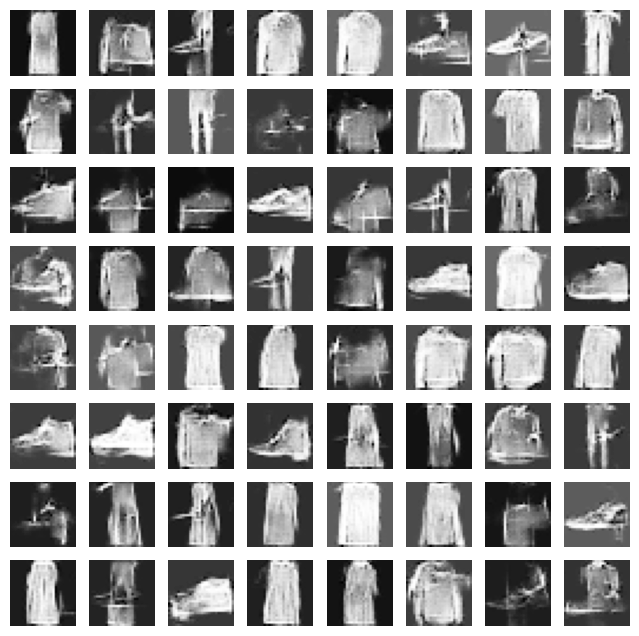

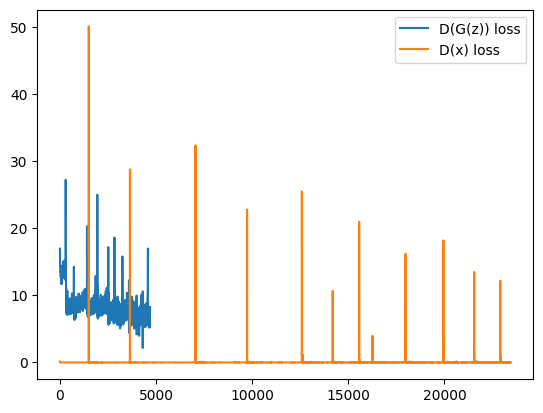

Time taken for epoch 5: 34.05929899215698

Epoch 6
-------------------------------
loss D: 0.0045, loss G: 6.2849
loss D: 0.0091, loss G: 7.6084
loss D: 0.0033, loss G: 8.2366
loss D: 0.0333, loss G: 6.6162
loss D: 0.0078, loss G: 6.5150
loss D: 0.0118, loss G: 7.6194
loss D: 0.0076, loss G: 6.8543
loss D: 0.0047, loss G: 7.1368
loss D: 0.0066, loss G: 7.1749
loss D: 0.0105, loss G: 6.0937
Avg loss: 0.0195


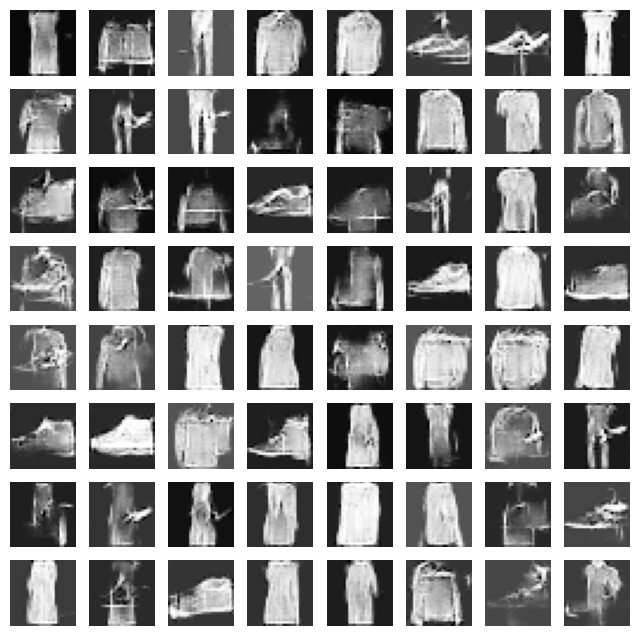

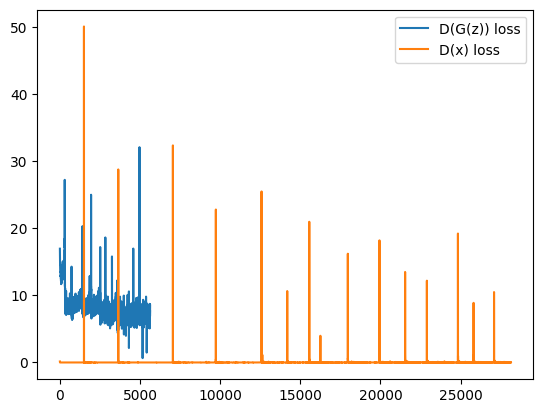

Time taken for epoch 6: 35.292954444885254

Epoch 7
-------------------------------
loss D: 0.0041, loss G: 7.3582
loss D: 0.0062, loss G: 7.4028
loss D: 0.0623, loss G: 7.6179
loss D: 0.0267, loss G: 7.1988
loss D: 0.0061, loss G: 7.6285
loss D: 0.0142, loss G: 5.3845
loss D: 0.0184, loss G: 7.2513
loss D: 0.0177, loss G: 5.8305
loss D: 0.0100, loss G: 6.5028
loss D: 0.0243, loss G: 5.8270
Avg loss: 0.0240


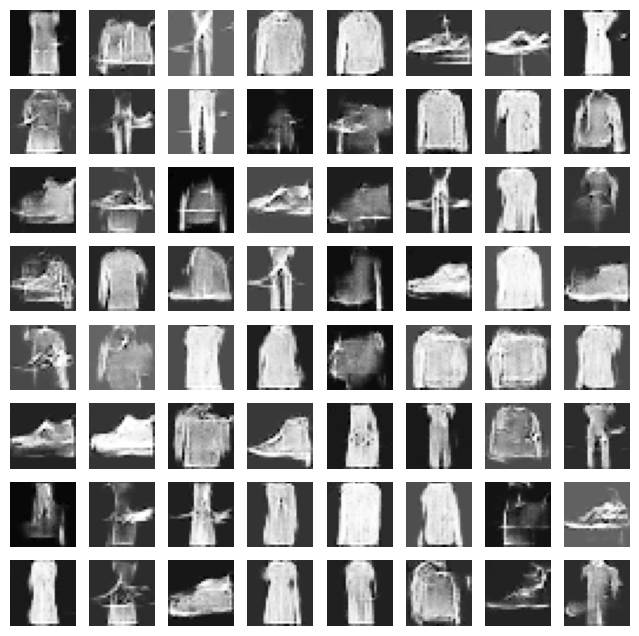

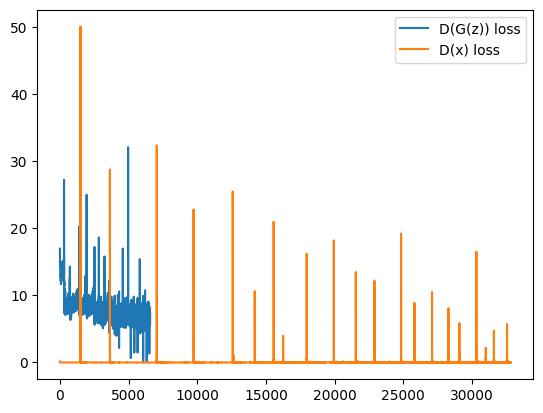

Time taken for epoch 7: 34.81427597999573

Epoch 8
-------------------------------
loss D: 0.0199, loss G: 6.2382
loss D: 0.0075, loss G: 6.5264
loss D: 0.0128, loss G: 6.0067
loss D: 0.0146, loss G: 6.5099
loss D: 0.0044, loss G: 7.8223
loss D: 0.0099, loss G: 7.3629
loss D: 0.0117, loss G: 6.9918
loss D: 0.0198, loss G: 5.9306
loss D: 0.0102, loss G: 7.0189
loss D: 0.0109, loss G: 6.1181
Avg loss: 0.0290


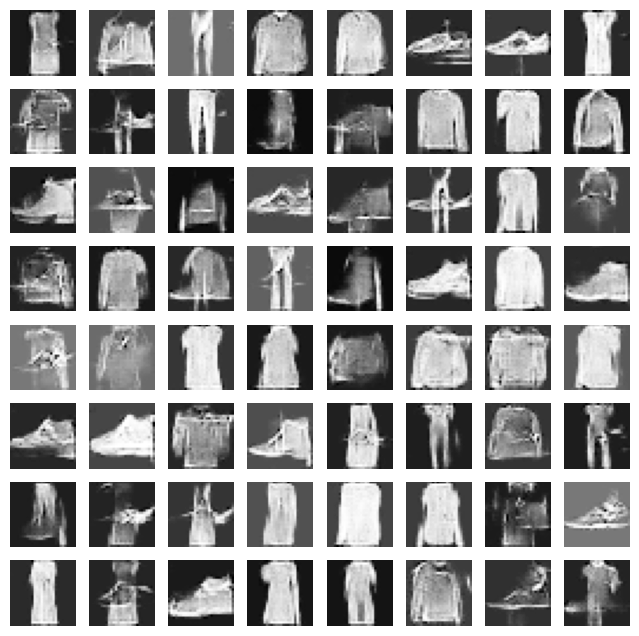

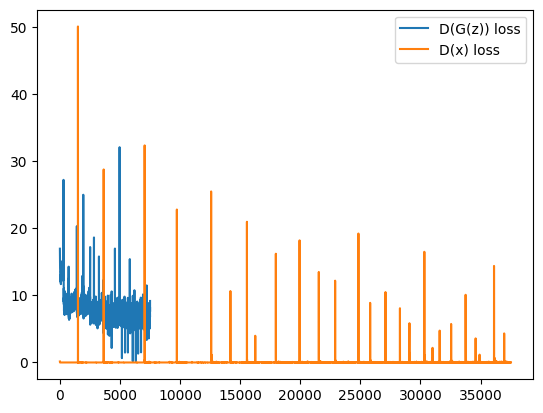

Time taken for epoch 8: 40.23974657058716

Epoch 9
-------------------------------
loss D: 0.0119, loss G: 6.9069
loss D: 0.0079, loss G: 7.6914
loss D: 0.0052, loss G: 6.7968
loss D: 0.0188, loss G: 7.1101
loss D: 0.0039, loss G: 7.8238
loss D: 0.0099, loss G: 7.5182
loss D: 0.0090, loss G: 8.2223
loss D: 0.0110, loss G: 5.5567
loss D: 0.0098, loss G: 7.4106
loss D: 0.0315, loss G: 7.3760
Avg loss: 0.0315


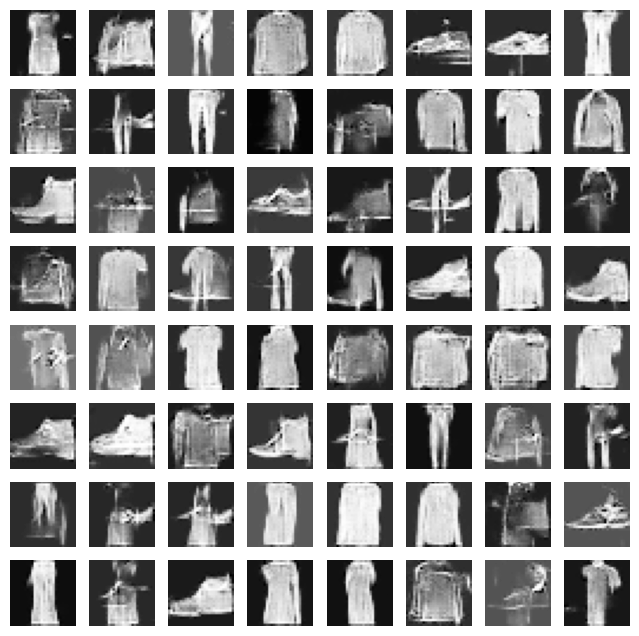

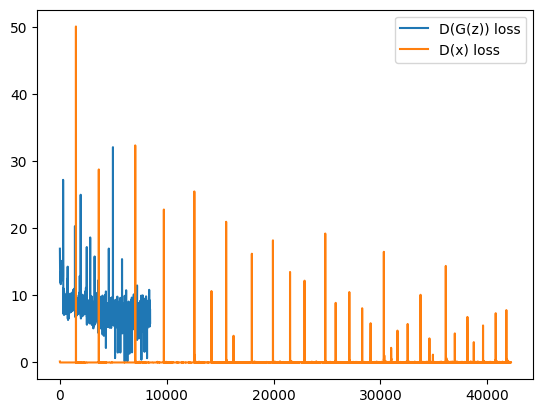

Time taken for epoch 9: 42.02174210548401

Epoch 10
-------------------------------
loss D: 0.0231, loss G: 8.0382
loss D: 0.0097, loss G: 7.8103
loss D: 0.0132, loss G: 7.9121
loss D: 0.0257, loss G: 7.4868
loss D: 0.0069, loss G: 6.7893
loss D: 0.0118, loss G: 6.5689
loss D: 0.0087, loss G: 7.2287
loss D: 0.0167, loss G: 6.6097
loss D: 0.0062, loss G: 7.0316
loss D: 0.0138, loss G: 7.8972
Avg loss: 0.0341


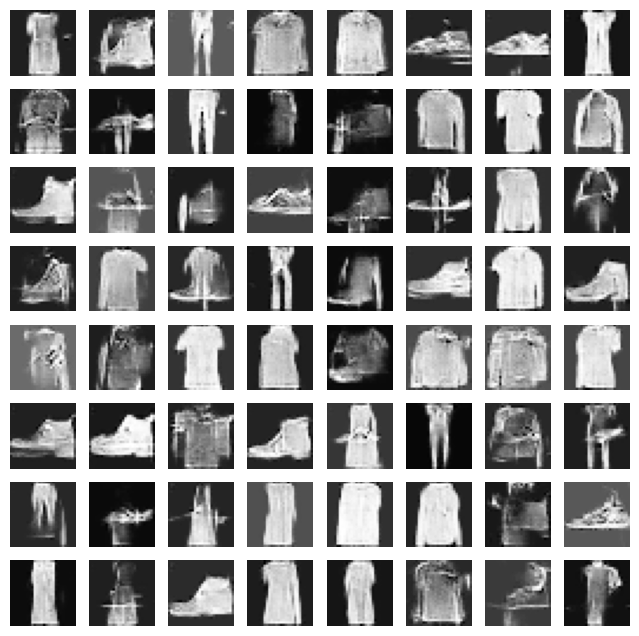

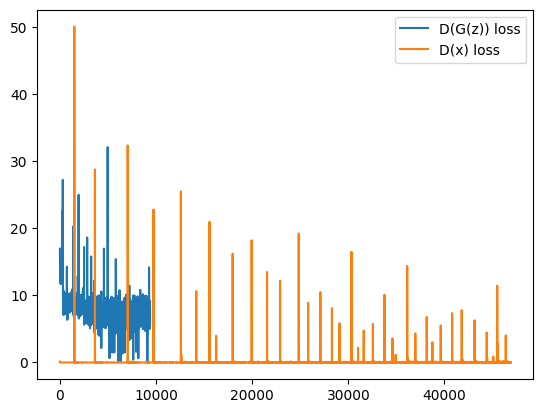

Time taken for epoch 10: 38.02902388572693

Total time for training: 407.14064288139343


In [69]:
totaltime = time.time()
for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    start = time.time()
    train_loop(train_dataloader, gen, disc, g_optimizer, d_optimizer, loss_fn)
    test_loop(test_dataloader, gen, disc, loss_fn)
    plot_images(gen, epoch, fixed_noise)
    plot_losses(gen_losses, disc_losses)
    
    print(f"Time taken for epoch {epoch+1}: {time.time() - start}\n")
print(f"Total time for training: {time.time() - totaltime}")